In [187]:
from gensim import corpora, models, similarities
import pandas as pd
import jieba
from collections import Counter
import seaborn as sns

In [146]:
# read in data

pubhealth = pd.read_csv("PUBHEALTH/train.tsv", sep='\t')
dev = pd.read_csv("PUBHEALTH/dev.tsv", sep='\t')
test = pd.read_csv("PUBHEALTH/test.tsv", sep='\t')

print(len(pubhealth))

# drop columns with no claims
pubhealth = pubhealth.dropna(subset='claim')
print(len(pubhealth))


dev = dev.dropna(subset='claim')
test = test.dropna(subset='claim')

9832
9824


In [147]:
# format tags columns in df

def format_tags(df):
    tags = []
    tag_lists = []

    for subjects in df.subjects:
        if type(subjects) is str:
            s = subjects.split(",")
        else:
            if type(subjects) is list:
                s = subjects
            else:
                s = []
        s = [t.lstrip().rstrip() for t in s]
        tag_lists.append(s)
        for tag in s:
            tags.append(tag)
    df['tags'] = tag_lists
    return df, tags

In [150]:
# format

pubhealth, pubhealth_tags = format_tags(pubhealth)
dev, dev_tags = format_tags(dev)
test, test_tags = format_tags(test)

## Use Gensim model with whole training set

In [151]:
# format pubhealth dataset for gensim

claims = list(pubhealth["claim"])
texts = [jieba.lcut(text) for text in claims]
dictionary = corpora.Dictionary(texts)
feature_cnt = len(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)     

In [152]:
# claim = 'Dryer sheets are one of the very worst things from a chemical allergy standpoint.'
claim = "Chlorine in water causes gray hair."

In [153]:
# claim

kw_vector = dictionary.doc2bow(jieba.lcut(claim))

# similarity

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
sim = index[tfidf[kw_vector]]

In [154]:
sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
top_claim = sim_df.sort_values("similarity", ascending=False).iloc[0]['claim']

print("INITIAL CLAIM: ", claim)
print("")
print(sim)
print("")
print("SIMILAR CLAIM: ", top_claim)

INITIAL CLAIM:  Chlorine in water causes gray hair.

0.31056017

SIMILAR CLAIM:  People are putting hair removal creams in conditioner, causing hair loss.


In [155]:
pubhealth[pubhealth['claim'] == top_claim]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,tags
1572,36272,People are putting hair removal creams in cond...,"August 1, 2019",Is Someone Putting Nair in Hair Conditioner Bo...,Kim LaCapria,A pair of posts shared to Facebook on July 28 ...,https://www.truthorfiction.com/officemax-bulle...,unproven,"Fact Checks, Viral Content","[Fact Checks, Viral Content]"


# Gensim model with only health tagged claims

In [156]:
health_tags = ['Health', 'Health News', "Health Care", 'Medical', 'Public Health']

In [158]:
def health(x):
    for t in health_tags:
        if t in x:
            return True
    return False

mask = pubhealth.tags.apply(lambda x: health(x))
health_df = pubhealth[mask]

In [159]:
# format pubhealth dataset for gensim

claims = list(health_df["claim"])
texts = [jieba.lcut(text) for text in claims]
dictionary = corpora.Dictionary(texts)
feature_cnt = len(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus) 

In [160]:
#claim = 'Dryer sheets are one of the very worst things from a chemical allergy standpoint.'
#claim = "Chlorine in water causes gray hair."
# claim = 'Cranberry juice is good for UTI.'
claim = 'My hypothesis is that you should train your body how to properly and quickly flush itself of lactic acid without supplements.'

In [161]:
# claim

kw_vector = dictionary.doc2bow(jieba.lcut(claim))

# similarity

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
sim = index[tfidf[kw_vector]]

In [162]:
sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
top_claim = sim_df.sort_values("similarity", ascending=False).iloc[0]['claim']

print("INITIAL CLAIM: ", claim)
print("")
print(sim)
print("")
print("SIMILAR CLAIM: ", top_claim)

INITIAL CLAIM:  My hypothesis is that you should train your body how to properly and quickly flush itself of lactic acid without supplements.

0.2626656

SIMILAR CLAIM:  Mixing cream of tartar with orange juice will flush nicotine from your body and help you quit smoking faster. 


In [163]:
pubhealth[pubhealth['claim'] == top_claim]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,tags
8485,34070,Mixing cream of tartar with orange juice will ...,"October 24, 2019",Because no published support exists for the cl...,Alex Kasprak,A viral story on Shareably first published in ...,,false,Medical,[Medical]


## Gensim model with only health tagged claims tested on dev set

In [165]:
dev_mask = dev.tags.apply(lambda x: health(x))
dev_health_df = dev[mask]

/var/folders/__/6ygy68tn6c74340_57scyx500000gn/T/ipykernel_67600/2225327524.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dev_health_df = dev[mask]


In [170]:
len(dev_health_df)

448

In [176]:
initial_claims = []
initial_label = []
gensim_claims = []
gensim_label = []
sims = []

for i in range(len(dev_health_df['claim'])):
    # claim
    if i % 25 == 0:
        print("On " + str(i) + " out of " + str(len(dev_health_df)))
    claim = dev_health_df.iloc[i]['claim']
    kw_vector = dictionary.doc2bow(jieba.lcut(claim))

    # similarity
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
    sim = index[tfidf[kw_vector]]
    
    sim_df = pd.DataFrame({"claim": claims, "similarity": sim})
    sim = sim_df.sort_values("similarity", ascending=False).iloc[0]['similarity']
    top_claim = sim_df.sort_values("similarity", ascending=False).iloc[0]['claim']
    top_label = pubhealth[pubhealth['claim'] == top_claim].iloc[0]['label']
    
    initial_claims.append(claim)
    initial_label.append(dev_health_df[dev_health_df["claim"] == claim].iloc[0]['label'])
    sims.append(sim)
    gensim_claims.append(top_claim)
    gensim_label.append(top_label)

On 0 out of 448
On 25 out of 448
On 50 out of 448
On 75 out of 448
On 100 out of 448
On 125 out of 448
On 150 out of 448
On 175 out of 448
On 200 out of 448
On 225 out of 448
On 250 out of 448
On 275 out of 448
On 300 out of 448
On 325 out of 448
On 350 out of 448
On 375 out of 448
On 400 out of 448
On 425 out of 448


In [177]:
final_dev = pd.DataFrame({"initial claim": initial_claims, \
                          "initial label": initial_label, \
                          "gensim claim": gensim_claims, \
                          "gensim label": gensim_label, \
                          "similarity": sims})

In [181]:
final_dev

,initial claim,initial label,gensim claim,gensim label,similarity
0,School closures will have little impact on COV...,true,School district offer birth control in high sc...,true,0.273244
1,More infected in fresh wave of China bird flu ...,true,Death toll from new China bird flu rises: WHO.,true,0.345577
2,Raw Milk Straight from the Cow,true,Straight-talking Fauci explains outbreak to a ...,true,0.420198
3,Trump: Asian-Americans not responsible for vir...,true,Heroic nurses need full protection against cor...,true,0.339628
4,"November 29, 2017","National, Candidate Biography, Donald Trump,",The FDA published “conclusive proof” that the...,false,0.327621
...,...,...,...,...,...
443,"We're not engaged in nation-building"" in Afgha...",mixture,“We’re down near the low end of per capita dea...,false,0.227977
444,There are reports of suicides and even murd...,mixture,"This is COVID-19, not COVID-1, folks. And so y...",false,0.179715
445,"The state of Florida has seen ""double-digit dr...",true,"""Sexting"""" again linked to risky sex among tee...",true,0.309186
446,Sylentis announces the results of tivanisiran ...,mixture,Minnesota OKs medical cannabis for chronic pai...,true,0.202549


In [198]:
final_dev['score'] = final_dev['initial label'] == final_dev['gensim label']

# average score for all predictions

sum(final_dev['score'])/len(final_dev)

0.5580357142857143

/var/folders/__/6ygy68tn6c74340_57scyx500000gn/T/ipykernel_67600/3482985148.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=final_dev['similarity'],bins=10,kde=False)


<AxesSubplot: >

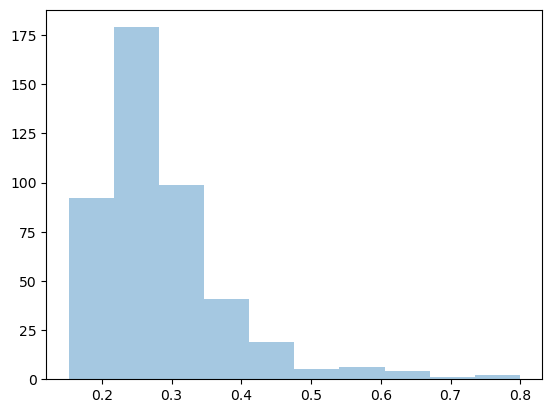

In [197]:
# looking at overall similarity scores

sns.distplot(x=final_dev['similarity'],bins=10,kde=False)

In [204]:
# average score for predictions with over .3 similarity

sum(final_dev[final_dev['similarity'] > 0.3]['score'])/len(final_dev[final_dev['similarity'] > 0.3])

0.6896551724137931

In [205]:
# average score for predictions with over .4 similarity

sum(final_dev[final_dev['similarity'] > 0.4]['score'])/len(final_dev[final_dev['similarity'] > 0.4])

0.8

In [206]:
# average score for predictions with over .4 similarity

sum(final_dev[final_dev['similarity'] > 0.5]['score'])/len(final_dev[final_dev['similarity'] > 0.5])

0.9333333333333333

## Normal Classifiers